## Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Get Data

In [42]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Overview

In [85]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### Cities

<ul>
    <li>Create a new dataframe by wrangling the dataframe to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of flights (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of all weekly totals.

In [86]:
weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']

from_flights = dat.groupby(['from'])[weeklies_].sum()
to_flights = dat.groupby(['to'])[weeklies_].sum()

sdat = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
sdat = sdat.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or 
                                                                  # to a city, replace NA by 0
sdat = sdat.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

sdat['total_weekly_flights'] = sdat.apply(lambda row: 
                                                        row.from_weekly_flights + row.to_weekly_flights,
                                                        axis = 1)
sdat['total_weekly_capacity'] = sdat.apply(lambda row: 
                                                        row.from_weekly_capacity + row.to_weekly_capacity,
                                                        axis = 1)
sdat['total_weekly_est_pass'] = sdat.apply(lambda row: 
                                                        row.from_weekly_est_pass + row.to_weekly_est_pass,
                                                        axis = 1)

sdat.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_flights,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


#### Top Cities by Weekly Total Movements

20 cities account for 80% of all arrivals and departures.

Cities accounting for 80% of all arrivals and departures:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh']


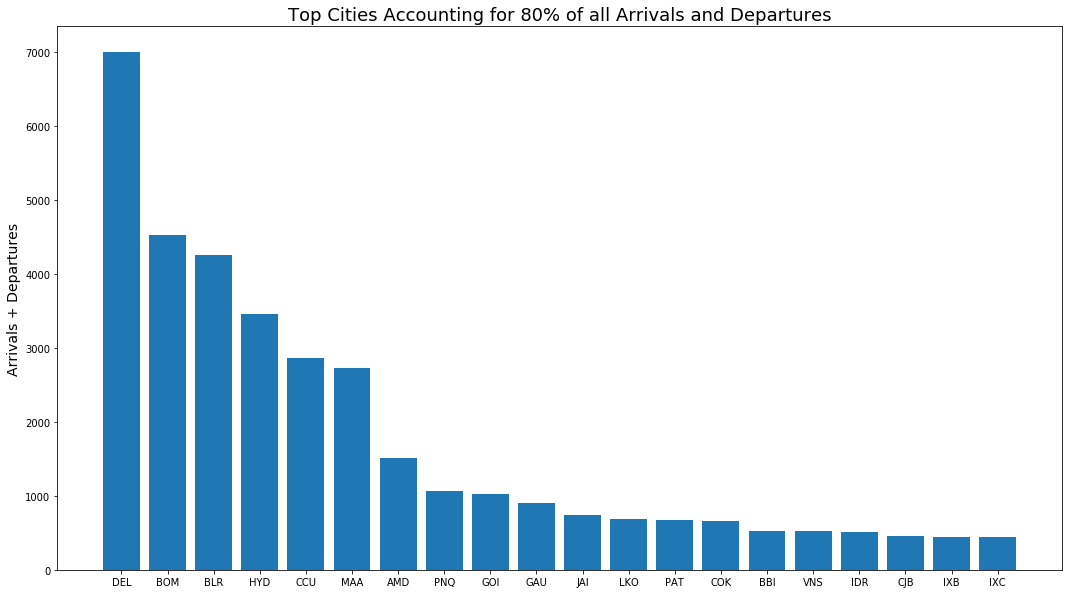

In [87]:


sdat = sdat.sort_values(by = ['total_weekly_flights'], ascending = False)
total_ = sdat['total_weekly_flights'].sum()

sdat['%_total_weekly_flights'] = round(sdat['total_weekly_flights'].cumsum()/total_, 2)

top_cities_by_mvmnts = sdat.loc[sdat['%_total_weekly_flights'] <= 0.8, :].index.tolist()
top_cities_by_name = [codes_to_city[top_cities_by_mvmnts[i]] for i in range(len(top_cities_by_mvmnts))]

print('%i cities account for 80%% of all arrivals and departures.\n' % len(top_cities_by_mvmnts))
print('Cities accounting for 80% of all arrivals and departures:\n', top_cities_by_name)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_by_mvmnts, sdat['total_weekly_flights'][0:len(top_cities_by_mvmnts)])
plt.title('Top Cities Accounting for 80% of all Arrivals and Departures', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Top Cities by Weekly Total Capacity

17 cities account for 80% of total weekly capacity.

Cities accounting for 80% of total weekly capacity:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Indore', 'Varanasi']


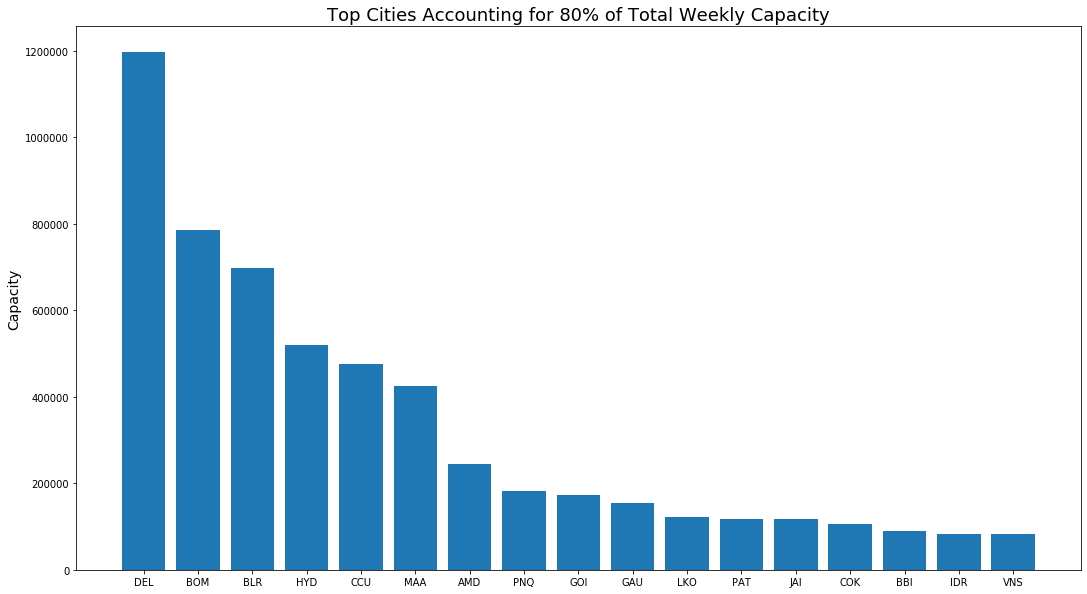

In [88]:
sdat = sdat.sort_values(by = ['total_weekly_capacity'], ascending = False)
total_ = sdat['total_weekly_capacity'].sum()

sdat['%_total_weekly_capacity'] = round(sdat['total_weekly_capacity'].cumsum()/total_, 2)

top_cities_by_cap = sdat.loc[sdat['%_total_weekly_capacity'] <= 0.8, :].index.tolist()
top_cities_by_name = [codes_to_city[top_cities_by_cap[i]] for i in range(len(top_cities_by_cap))]

print('%i cities account for 80%% of total weekly capacity.\n' % len(top_cities_by_cap))
print('Cities accounting for 80% of total weekly capacity:\n', top_cities_by_name)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_by_cap, sdat['total_weekly_capacity'][0:len(top_cities_by_cap)])
plt.title('Top Cities Accounting for 80% of Total Weekly Capacity', size = 18)
plt.ylabel('Capacity', size = 14)
plt.show()

#### Top Cities by Weekly Total Estimated Passengers

17 cities account for 80% of total estimated weekly passengers.

Cities accounting for 80% of total estimated weekly passengers:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore']


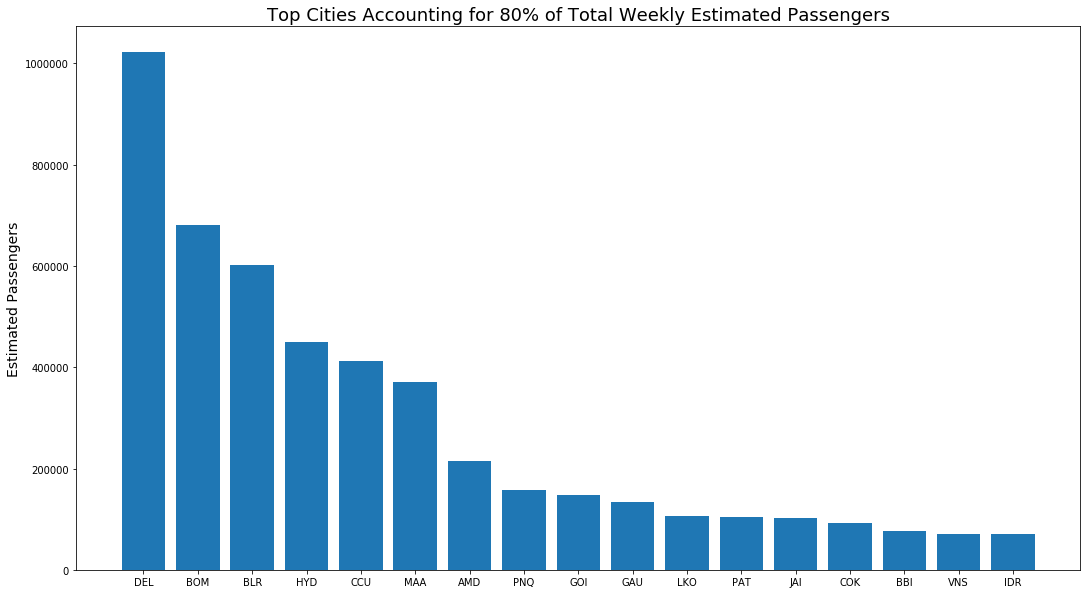

In [89]:
sdat = sdat.sort_values(by = ['total_weekly_est_pass'], ascending = False)
total_ = sdat['total_weekly_est_pass'].sum()

sdat['%_total_weekly_est_pass'] = round(sdat['total_weekly_est_pass'].cumsum()/total_, 2)

top_cities_by_pass = sdat.loc[sdat['%_total_weekly_est_pass'] <= 0.8, :].index.tolist()
top_cities_by_name = [codes_to_city[top_cities_by_pass[i]] for i in range(len(top_cities_by_pass))]

print('%i cities account for 80%% of total estimated weekly passengers.\n' % len(top_cities_by_pass))
print('Cities accounting for 80% of total estimated weekly passengers:\n', top_cities_by_name)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_by_pass, sdat['total_weekly_est_pass'][0:len(top_cities_by_pass)])
plt.title('Top Cities Accounting for 80% of Total Weekly Estimated Passengers', size = 18)
plt.ylabel('Estimated Passengers', size = 14)
plt.show()

### Day-of-Week

#### Distribution of Total Movements

<ul>
    <li>Plot the day-wise distribution for all arrivals and departures combined across all cities.
    <li>For the top cities by total weekly movements, for each city:
        <ol>
            <li>identify all schedules in and out of the city.
            <li>group the schedules by day of the week and count the total number of flights for the day.
            <li>plot the spread of the total daily movements for the city

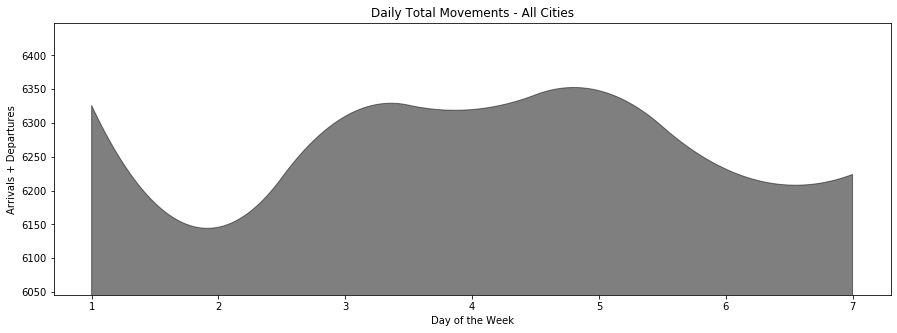

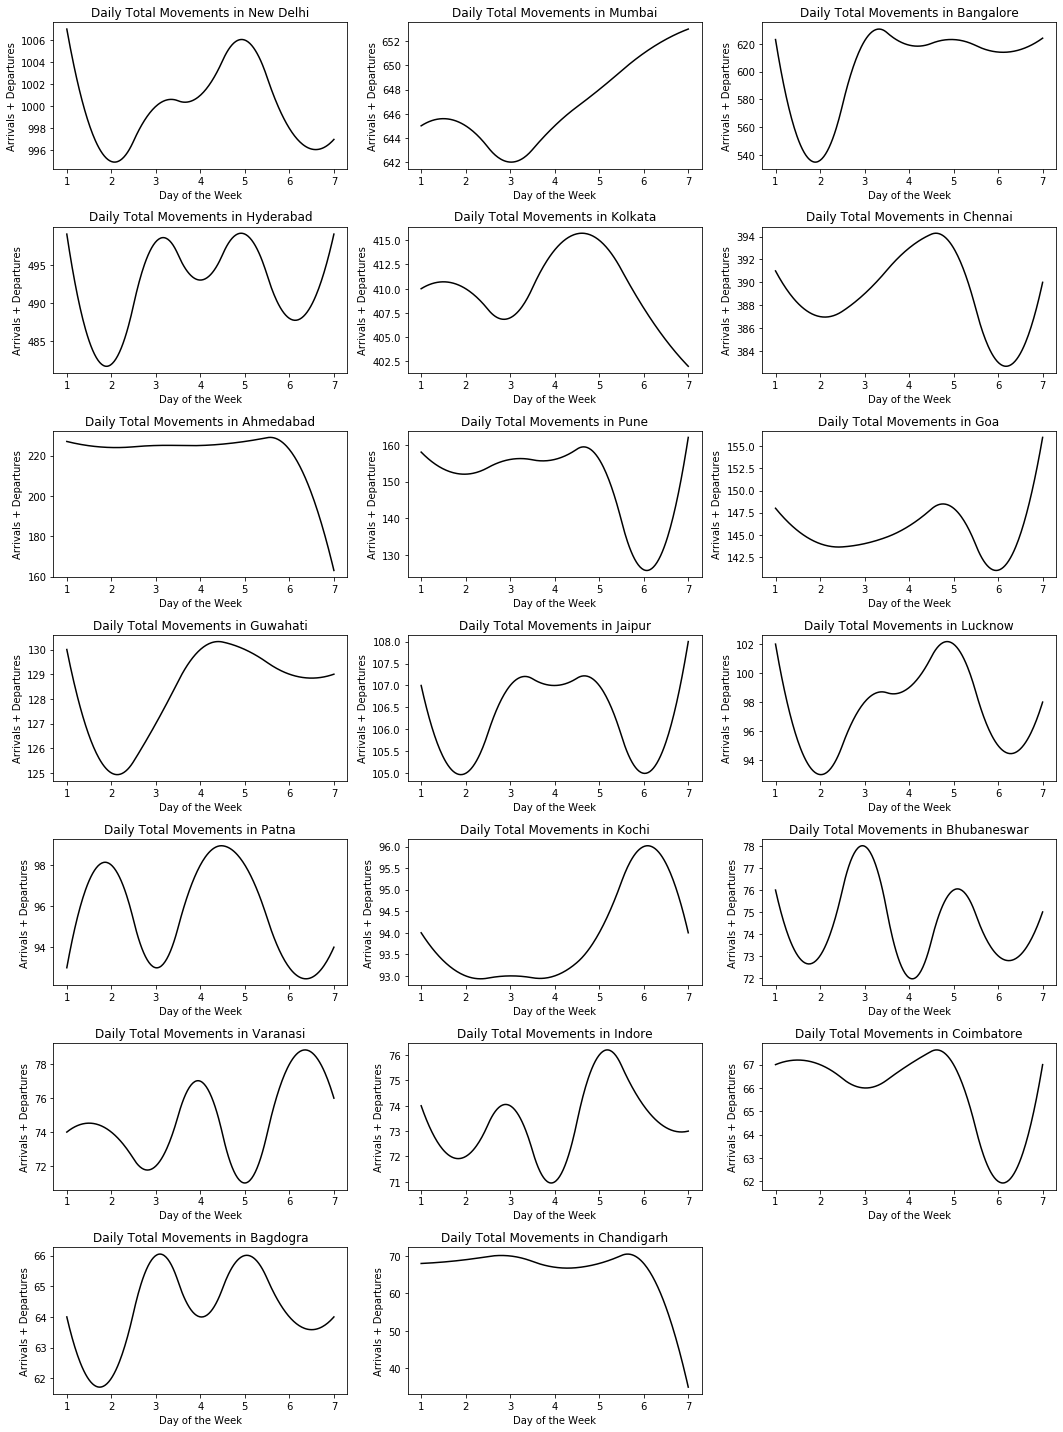

In [108]:
''' When combined across all cities, for any day, the total number of arrivals must be equal to the total 
number of departures. However, this may not be true when considering a particular city, i.e. the total number 
of arrivals in a city may not be the same as the total number of departures '''

plt.figure(figsize = (15, 5))

daily_mvmnts_from = []
daily_mvmnts = []
for i in range(1,8,1):
    day = 'day_' + str(i)
    daily_mvmnts_from.append(dat.groupby([day, 'from'])[day].count()[1].sum())
    
daily_mvmnts = [i*2 for i in daily_mvmnts_from]

# Interpreting data to plot smooth spline curves
x_days = np.arange(1, 8 ,1)
x_axis = np.linspace(1, 7, 300)

spline = make_interp_spline(x_days, daily_mvmnts, k = 2)
y_axis = spline(x_axis)
plt.fill_between(x_axis, y_axis, color = 'black', alpha = 0.5)
plt.ylim((min(daily_mvmnts) - 100, max(daily_mvmnts) + 100))
plt.xlabel('Day of the Week')
plt.ylabel('Arrivals + Departures')
plt.title('Daily Total Movements - All Cities')
plt.show()

plt.figure(figsize = (15, 20))
ncol = 3
nrow = np.ceil(len(top_cities_by_mvmnts)/3)
subplot_= 1

for city_code in top_cities_by_mvmnts:
    daily_mvmnts_in =[]
    daily_mvmnts_out = []
    daily_mvmnts = []
    
    idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
    sdat = dat.iloc[idx, :]
        
    idx_in = [i for i in sdat.index if sdat['from'][i] != city_code] # flights into the city
    idx_out = [i for i in sdat.index if sdat['to'][i] != city_code]  # flights out of the city
    
    for i in range(1,8,1):
        day = 'day_' + str(i)
        daily_mvmnts_in.append(sdat.loc[idx_in, :].groupby([day, 'from'])[day].count()[1].sum())
        daily_mvmnts_out.append(sdat.loc[idx_out, :].groupby([day, 'to'])[day].count()[1].sum())
    
    daily_mvmnts = [sum(x) for x in zip(daily_mvmnts_in, daily_mvmnts_out)] # total flights into and out of the city
      
    plt.subplot(nrow, ncol, subplot_)
    subplot_ = subplot_ + 1
    
    spline = make_interp_spline(x_days, daily_mvmnts, k = 2)
    y_axis = spline(x_axis)
    plt.plot(x_axis, y_axis, color = 'black')
    
    '''spline = make_interp_spline(x_days, daily_mvmnts_in, k = 2)
    y_axis = spline(x_axis)
    plt.plot(x_axis, y_axis, color = 'red', label = 'arrivals')
    
    spline = make_interp_spline(x_days, daily_mvmnts_out, k = 2)
    y_axis = spline(x_axis)
    plt.plot(x_axis, y_axis, color = 'blue', label = 'departures')
    
    plt.legend()'''
    
    plt.xlabel('Day of the Week')
    plt.ylabel('Arrivals + Departures')
    plt.title('Daily Total Movements in %s' % codes_to_city[city_code])

plt.tight_layout()
plt.show()

### Time-of-Day Distribution

In [1]:
def fill_missing(series, slots, na_val):
    
    '''
    
    In a series with an expected numerically ascending index, identifies if a particular index value
    is missing and inserts a new entry with such missing index value with the desired na_val.
    
    Finally, reorder the new series to ensure that the inserted index values are in their appropriate 
    position
    
    '''
    
    if series.shape[0] != slots:
        missing_idx = list(set(np.arange(1, slots+1, 1)).difference(series.index))
        for i in missing_idx:
            series[float(i)] = na_val
    
    series = series.sort_index()
    return series

In [2]:
def plot_hourly(timeslot_arr, timeslot_dep, city_name = 'All Cities'):
    
    '''
    
    Smoothes the timeslot_arr and timeslot_dep series using splines and then plots the series.
    
    '''
    
    x_timeslots = np.arange(1, 49, 1)
    x_axis = np.linspace(1, 48, 300)
    smoothing_param = 3
    
    spline = make_interp_spline(x_timeslots, timeslot_arr, k = smoothing_param)
    y_axis = np.maximum(np.zeros(300), spline(x_axis))
    plt.fill_between(x_axis, y_axis, label = 'arrivals', color = 'red', alpha = 0.5)
    
    spline = make_interp_spline(x_timeslots, timeslot_dep, k = smoothing_param)
    y_axis = np.maximum(np.zeros(300), spline(x_axis))
    plt.fill_between(x_axis, y_axis, label = 'departures', color = 'blue', alpha = 0.5)
    plt.xlim((1, 50))
    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1)) # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'grey', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'grey', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'grey', linestyle = '--')         # 6 p.m.
    plt.xlabel('Hour of the Day')
    plt.ylabel('Arrivals + Departures')
    plt.title('Hourly Movements for the Week - %s' % city_name)
    plt.legend()

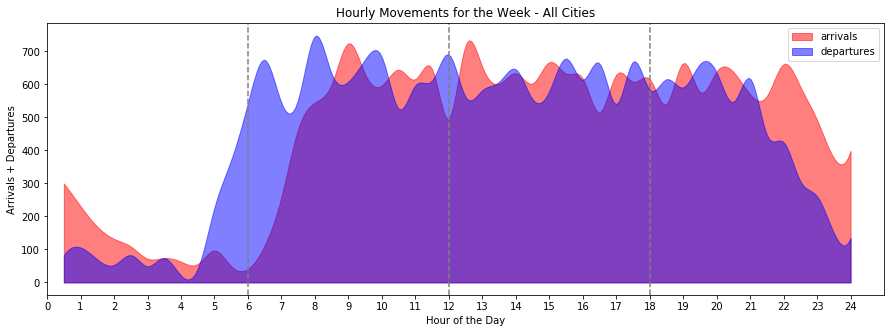

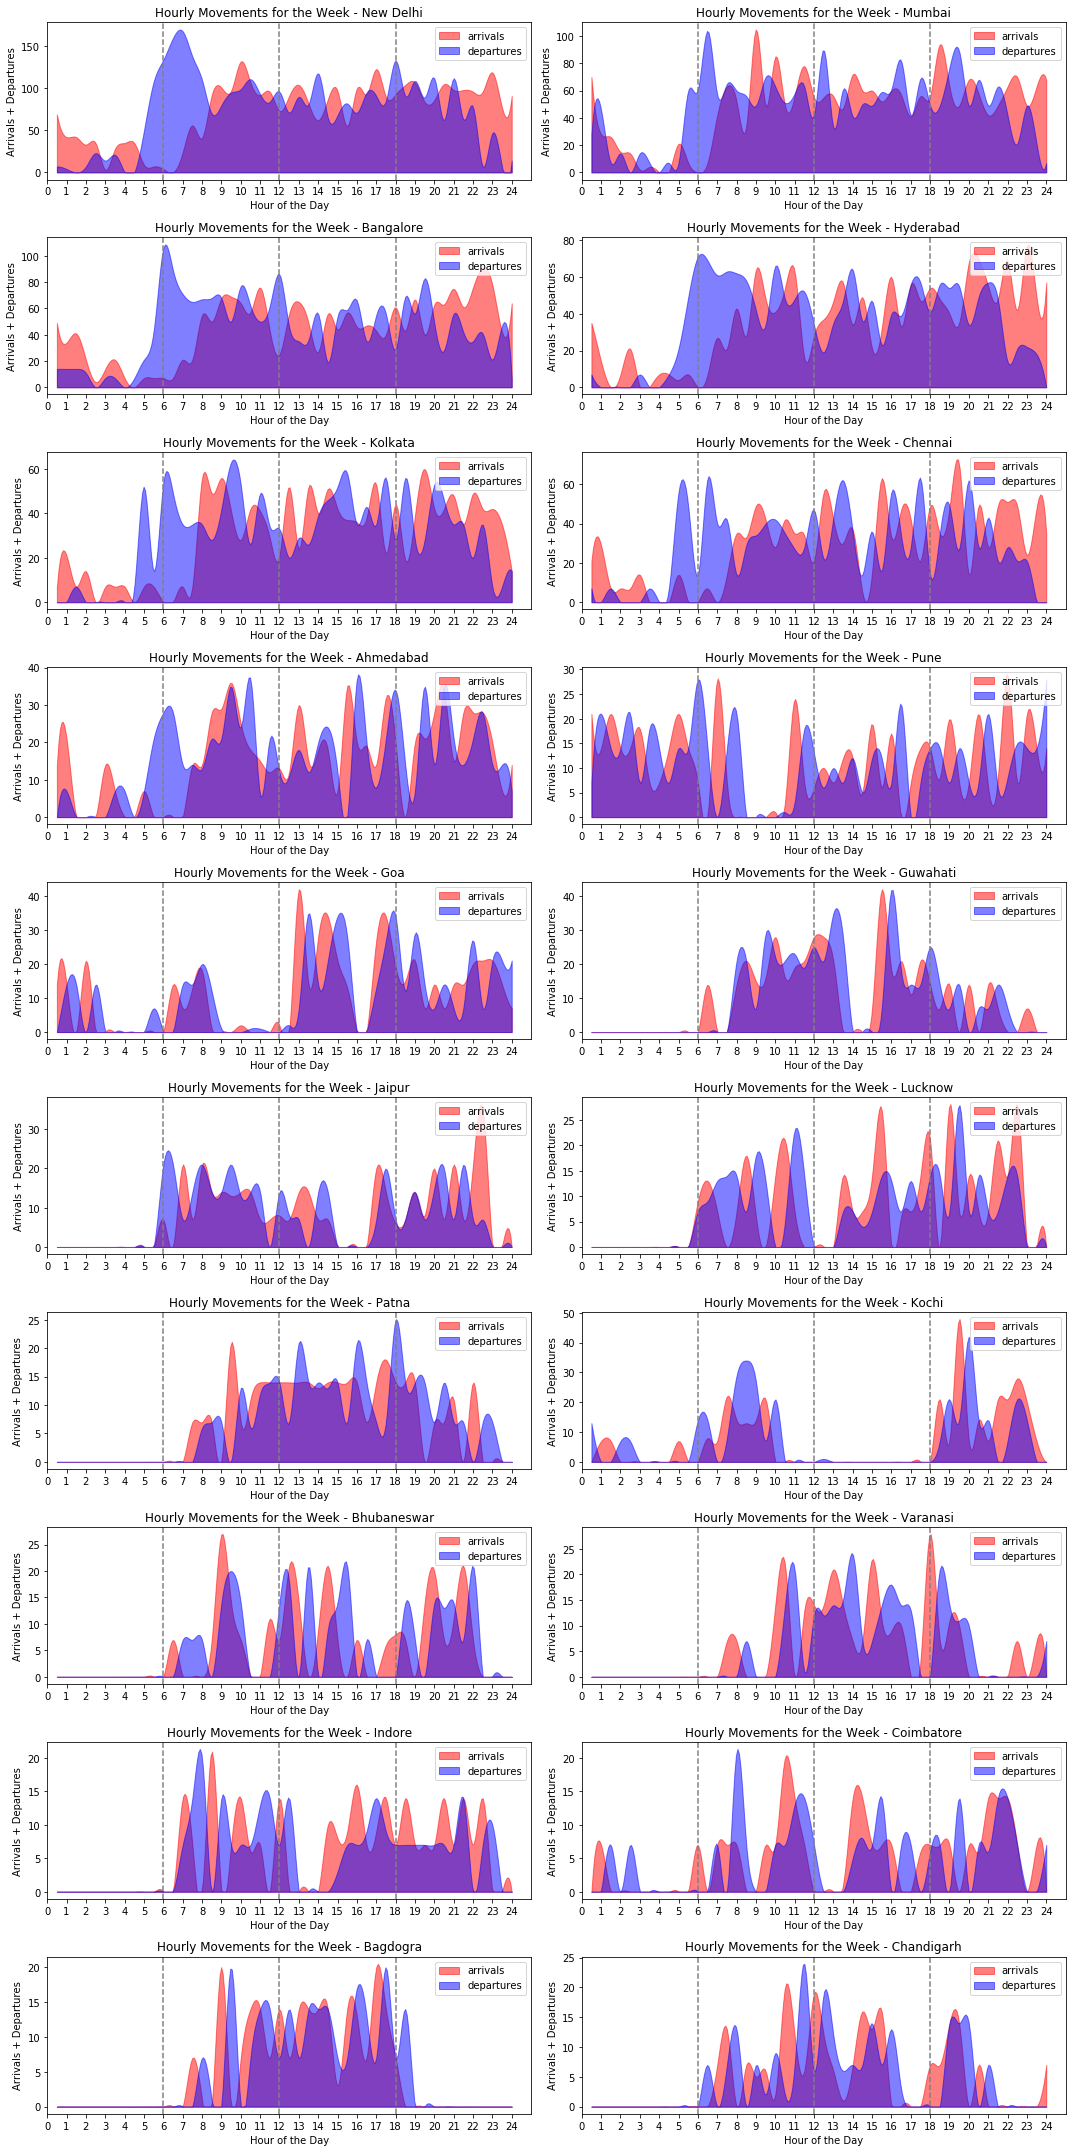

In [151]:
''' When combined across all cities, for any day, the total number of arrivals must be equal to the total 
number of departures. However, this may not be true when considering a particular city, i.e. the total number 
of arrivals in a city may not be the same as the total number of departures '''

plt.figure(figsize = (15, 5))

timeslot_arr = (dat.groupby(['to_time_slot'])['weekly_flights'].sum())
timeslot_arr = fill_missing(timeslot_arr, 48, 0)
timeslot_dep = (dat.groupby(['from_time_slot'])['weekly_flights'].sum())
timeslot_dep = fill_missing(timeslot_dep, 48, 0)

plot_hourly(timeslot_arr, timeslot_dep)
plt.show()

plt.figure(figsize = (15, 30))
ncol = 2
nrow = np.ceil(len(top_cities_by_mvmnts)/ncol)
subplot_= 1
for city_code in top_cities_by_mvmnts:
    timeslot_arr = []
    timeslot_dep = []
    
    idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
    sdat = dat.iloc[idx, :]
        
    idx_in = [i for i in sdat.index if sdat['to'][i] == city_code] # flights into the city
    idx_out = [i for i in sdat.index if sdat['from'][i] == city_code]  # flights out of the city
    
    timeslot_arr = (sdat.loc[idx_in, :].groupby(['to_time_slot'])['weekly_flights'].sum())
    timeslot_arr = fill_missing(timeslot_arr, 48, 0)
    timeslot_dep = (sdat.loc[idx_out, :].groupby(['from_time_slot'])['weekly_flights'].sum())
    timeslot_dep = fill_missing(timeslot_dep, 48, 0)
    
    plt.subplot(nrow, ncol, subplot_)
    plot_hourly(timeslot_arr, timeslot_dep, codes_to_city[city_code])
    subplot_ += 1

plt.tight_layout()
plt.show()

### Time-of-Day Distribution by Passenger Movement

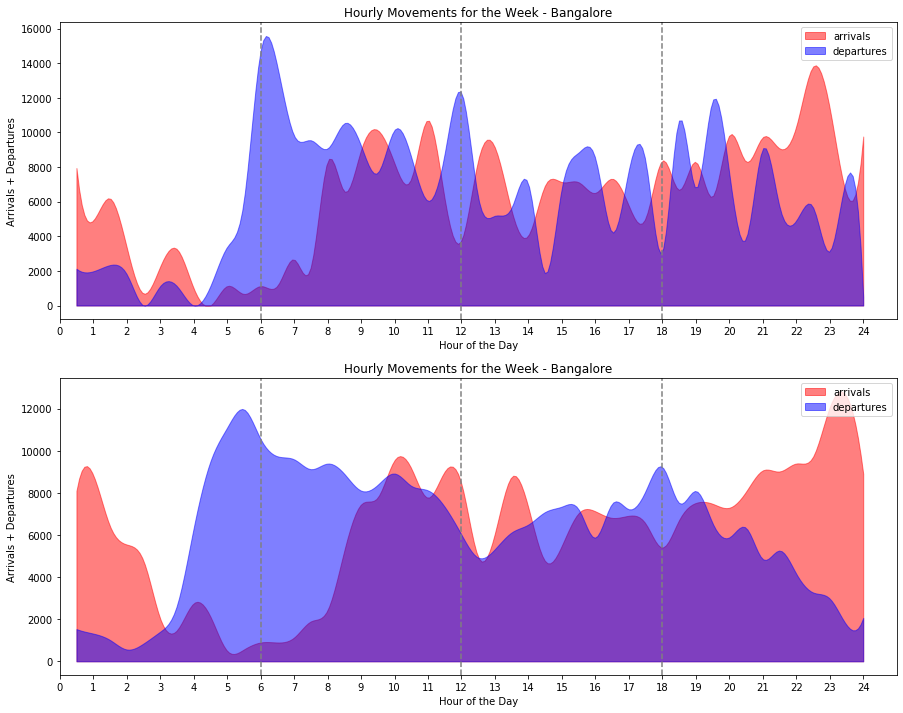

In [49]:
city_code = 'BLR'

timeslot_arr = []
timeslot_dep = []

idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
sdat = dat.iloc[idx, :]

idx_in = [i for i in sdat.index if sdat['to'][i] == city_code] # flights into the city
idx_out = [i for i in sdat.index if sdat['from'][i] == city_code]  # flights out of the city

# Timeslot wise passenger traffic on incoming flights
pass_in_timeslot = (sdat.loc[idx_in, :].groupby(['to_time_slot'])['weekly_est_pass'].sum())
pass_in_timeslot = fill_missing(pass_in_timeslot, 48, 0)
#Timeslot wise passenger traffic on outgoing flights
pass_out_timeslot = (sdat.loc[idx_out, :].groupby(['from_time_slot'])['weekly_est_pass'].sum())
pass_out_timeslot = fill_missing(pass_out_timeslot, 48, 0)

'''Outgoing passengers start arriving at the airpot in 4 timeslots prior to the from_time_slot (evenly) and 
incoming passengers start departing from the airport in 2 slots post the to_time_slot (evenly). We adjust the 
timeslot passenger traffic values to reflect this spread.'''

in_slots = 2; out_slots = 4

pass_in_timeslot_adj = pd.Series(data = 0, index = pass_in_timeslot.index, dtype = 'float')
pass_out_timeslot_adj = pd.Series(data = 0, index = pass_out_timeslot.index, dtype = 'float')
        
for i in range(1, 49):              # spreading the passengers at the airport for incoming flights
    dist_ = pass_in_timeslot[i]/in_slots
    for j in range(i+1, i+3):
        if j > 48: j = j - 48
        pass_in_timeslot_adj[j] += dist_
        
for i in range(1, 49):              # spreading the passengers at the airport for outgoing flights
    dist_ = pass_out_timeslot[i]/out_slots
    for j in range(i-out_slots, i):
        if j < 1: j = 48 + j
        pass_out_timeslot_adj[j] += dist_

plt.figure(figsize = (15, 12))

plt.subplot(2, 1, 1)
plot_hourly(pass_in_timeslot, pass_out_timeslot, codes_to_city[city_code])

plt.subplot(2, 1, 2)
plot_hourly(pass_in_timeslot_adj, pass_out_timeslot_adj, codes_to_city[city_code])

plt.show()


In [40]:
print(timeslot_dep[47:], timeslot_dep_adj)

from_time_slot
47.0    7329.0
48.0     500.0
Name: weekly_est_pass, dtype: float64 from_time_slot
1.0     3914.5
2.0      250.0
3.0        0.0
4.0        0.0
5.0        0.0
6.0        0.0
7.0        0.0
8.0        0.0
9.0        0.0
10.0       0.0
11.0       0.0
12.0       0.0
13.0       0.0
14.0       0.0
15.0       0.0
16.0       0.0
17.0       0.0
18.0       0.0
19.0       0.0
20.0       0.0
21.0       0.0
22.0       0.0
23.0       0.0
24.0       0.0
25.0       0.0
26.0       0.0
27.0       0.0
28.0       0.0
29.0       0.0
30.0       0.0
31.0       0.0
32.0       0.0
33.0       0.0
34.0       0.0
35.0       0.0
36.0       0.0
37.0       0.0
38.0       0.0
39.0       0.0
40.0       0.0
41.0       0.0
42.0       0.0
43.0       0.0
44.0       0.0
45.0       0.0
46.0       0.0
47.0       0.0
48.0    3664.5
dtype: float64
